<a href="https://colab.research.google.com/github/fryall/fofo/blob/main/try1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # import was correct
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D,GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten, Dense, InputLayer


<ipython-input-1-9b49285444bd>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm # import was correct


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
image_size=[224,224]
input_folder = '/content/drive/MyDrive/try1'
splitfolders.ratio(input_folder, output="twenty",
                   seed=42, ratio=(.7, .3),
                   group_prefix=None)

Copying files: 6271 files [02:23, 43.83 files/s] 


In [21]:
import tensorflow as tf

# Define the paths to the train and validation directories
train_dir = 'twenty/train'
val_dir = 'twenty/val'
test_dir = 'twenty/test'

# Load the training data
train_path = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)
# Load the validation data
test_path= tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical')



Found 4380 files belonging to 20 classes.
Found 1889 files belonging to 20 classes.


In [ ]:
from keras.applications import VGG16
VGG=VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [ ]:
VGG.trainable=False

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
model=Sequential()
model.add(InputLayer(input_shape=input_shape))
model.add(VGG)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=300,activation="relu"))
model.add(Dense(units=300,activation="relu"))
model.add(Dense(units=20,activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
print(VGG.output_shape)

(None, 7, 7, 512)


In [ ]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         153,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           6,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,964,908 (57.09 MB)

 Trainable params: 250,220 (977.42 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.keras", monitor="val_accuracy", verbose=1,
                             save_best_only=True, save_weights_only=False)
# Removed 'early' parameter as it's not part of ModelCheckpoint

early_stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=40,
                               verbose=1, mode='auto')
# Created a separate EarlyStopping callback

In [13]:
# Calculate the number of batches in your training dataset
num_train_samples =4380  # Replace with the actual number of training samples
num_batches = num_train_samples // 32  # Assuming batch_size is 32

# Set steps_per_epoch to the number of batches or a smaller value
steps_per_epoch = min(num_batches, 137)

# Update the model.fit call
history = model.fit(x=train_path, steps_per_epoch=30, epochs=10,
                 validation_data=test_path, validation_steps=1,
                 callbacks=[checkpoint])

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.1050 - loss: 6.1086 
Epoch 1: val_accuracy improved from -inf to 0.31250, saving model to vgg16_1.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 696s 22s/step - accuracy: 0.1076 - loss: 6.0468 - val_accuracy: 0.3125 - val_loss: 2.4228
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.3885 - loss: 2.0626 
Epoch 2: val_accuracy improved from 0.31250 to 0.59375, saving model to vgg16_1.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 649s 22s/step - accuracy: 0.3900 - loss: 2.0598 - val_accuracy: 0.5938 - val_loss: 1.7692
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5137 - loss: 1.8472 
Epoch 3: val_accuracy did not improve from 0.59375
30/30 ━━━━━━━━━━━━━━━━━━━━ 648s 22s/step - accuracy: 0.5138 - loss: 1.8446 - val_accuracy: 0.5938 - val_loss: 1.6278
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5551 - loss: 1.5343 
Epoch 4: val_accuracy improved from 0.59375 to 0.62500, saving model to vgg16_1.keras
30/

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 5: val_accuracy did not improve from 0.62500
30/30 ━━━━━━━━━━━━━━━━━━━━ 375s 12s/step - accuracy: 0.5241 - loss: 1.5754 - val_accuracy: 0.6250 - val_loss: 1.3039
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6714 - loss: 1.1325 
Epoch 6: val_accuracy did not improve from 0.62500
30/30 ━━━━━━━━━━━━━━━━━━━━ 650s 22s/step - accuracy: 0.6715 - loss: 1.1323 - val_accuracy: 0.5938 - val_loss: 1.1360
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7160 - loss: 1.0247 
Epoch 7: val_accuracy did not improve from 0.62500
30/30 ━━━━━━━━━━━━━━━━━━━━ 647s 22s/step - accuracy: 0.7155 - loss: 1.0252 - val_accuracy: 0.6250 - val_loss: 1.2321
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7215 - loss: 0.9376 
Epoch 8: val_accuracy improved from 0.62500 to 0.68750, saving model to vgg16_1.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 636s 21s/step - accuracy: 0.7215 - loss: 0.9363 - val_accuracy: 0.6875 - val_loss: 1.0489
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━

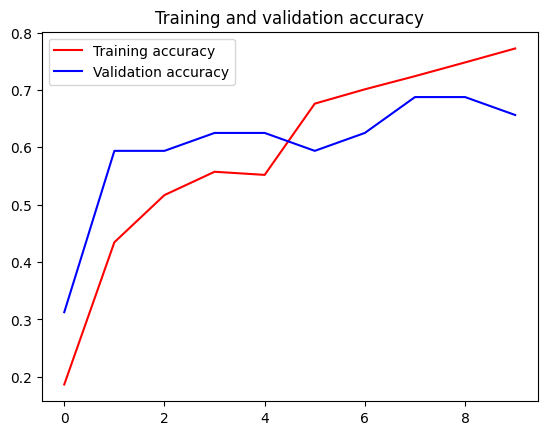

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 1208s 20s/step


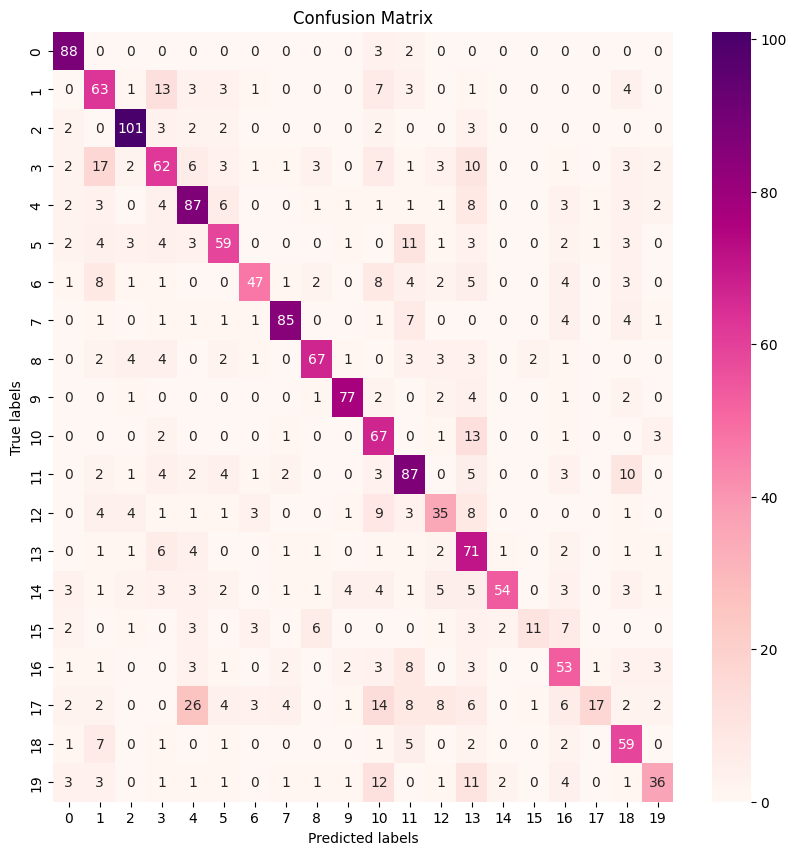

Validation Accuracy: 0.6490
Precision: 0.6850
Recall: 0.6365
F1 Score: 0.6326


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained model 'model' and test dataset 'test_path'
# Extract all test images and labels into numpy arrays
X_test = []
y_test = []
for images, labels in test_path:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

# Concatenate the batches into a single numpy array
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='RdPu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1 score, and accuracy
report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Display the calculated metrics
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

In [19]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 64.90%


In [24]:
# Save the entire model to a HDF5 file
model.save("my_model.h5")